Chris Holden (ceholden@gmail.com) - https://github.com/ceholden

Chapter 5: Classification of land cover
=======================================

## Introduction
In this chapter we will classify the Landsat image we've been working with using a supervised classification approach which incorporates the training data we worked with in [chapter 4](chapter_4_vector.ipynb). Specifically, we will be using the [RandomForest (Brieman 2001)](http://link.springer.com/article/10.1023/A:1010933404324) ensemble decision tree algorithm by [Leo Breiman and Adele Cutler](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm). The RandomForest algorithm has recently become extremely popular in the field of remote sensing, and is quite fast when compared to some other machine learning approaches (e.g., SVM can be quite computationally intensive). This isn't to say that it is the best per se; rather it is a great first step into the world of machine learning for classification and regression.

A few good resources for understanding RandomForest can be found:
+ [Breiman, Leo. 2001. Random Forests. Machine Learning 45-1: 5-32.](http://link.springer.com/article/10.1023/A:1010933404324)
+ [Wikipedia - Random Forest](http://en.wikipedia.org/wiki/Random_forest)
+ [Breiman and Cutler's website](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#workings)
+ [Blog entry from ŷhat](http://blog.yhathq.com/posts/random-forests-in-python.html)

A brief explanation of the RandomForest algorithm comes from the name. Rather than utilize the predictions of a single decision tree, the algorithm will take the ensemble result of a large number of decision trees (a forest of them). The "Random" part of the name comes from the term "bootstrap aggregating", or "bagging". What this means is that each tree within the forest only gets to train on some subset of the full training dataset (the subset is determined by sampling with replacement). The elements of the training data for each tree that are left unseen are held "out-of-bag" for estimation of accuracy. Randomness also helps decide which feature input variables are seen at each node in each decision tree. Once all individual trees are fit to the random subset of the training data, using a random set of feature variable at each node, the ensemble of them all is used to give the final prediction. 

In the classification mode, this means that if you were to have 5 classes being predicted using 500 trees, the output prediction would be the class that has the most number of the 500 trees predicting it. The proportion of the number of trees that voted for the winning class can be a diagnostic of the representativeness of your training data relative to the rest of the image. Taking the 500 trees example, if you have pixels which are voted to be in the "Forest" land cover class by 475 of 500 trees, you could say that this was a relatively certain prediction. On the other hand, if you have a pixel which gets 250 votes for "Forest" and 225 votes for "Shrub", you could interpret this as either an innately confusing pixel (maybe it is a mixed pixel, or it is a small statured forest) or as an indicator that you need more training data samples in these types of pixels.

Finally, Random Forest has some other benefits:
+ It gives you a measure of "variable important" which relates how useful your input features (e.g. spectral bands) were in the classification
+ The "out-of-bag" samples in each tree can be used to validate each tree. Grouping these predicted accuracies across all trees can [sometimes give you an unbiased estimate of the error rate](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#ooberr) similar to doing cross-validation.
+ Can be used for regressions, unsupervised clustering, or supervised classification
+ Available in many popular languages, including Python, R, and MATLAB
+ Free and open source, and fast

In [12]:
!git clone https://github.com/sbhsa1990/open-geo-tutorial /content/drive/MyDrive/open-geo-tutorial

Cloning into '/content/drive/MyDrive/open-geo-tutorial'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 384 (delta 8), reused 8 (delta 8), pack-reused 373
Receiving objects: 100% (384/384), 28.38 MiB | 22.95 MiB/s, done.
Resolving deltas: 100% (233/233), done.


In [8]:
!ls open-geo-tutorial

environment.yml  LICENSE		  Python  README.md
example		 open-geo-tutorial.Rproj  R	  requirements.txt


## scikit-learn

In this chapter we will be using the Random Forest implementation provided by the [scikit-learn](http://scikit-learn.org) library. `Scikit-learn` is an amazing machine learning library that provides easy and consistent interfaces to many of the most popular machine learning algorithms. It is built on top of the pre-existing scientific Python libraries, including NumPy, SciPy, and matplotlib, which makes it very easy to incorporate into your workflow. The number of available methods for accomplishing any task contained within the library is (in my opinion) its real strength. No single algorithm is best for all tasks under all circumstances, and `scikit-learn` helps you understand this by abstracting the details of each algorithm to simple consistent interfaces. For example:

In [13]:
from IPython.display import Image
img = Image('http://scikit-learn.org/stable/_images/plot_classifier_comparison_001.png')
img

FileNotFoundError: ignored

FileNotFoundError: ignored

<IPython.core.display.Image object>

[This figure](http://scikit-learn.org/stable/auto_examples/plot_classifier_comparison.html) shows the classification predictions and the decision surfaces produced for three classification problems using 9 different classifiers. What is even more impressive is that all of this took only about 110 lines of code, including comments!

## Preparing the dataset
#### Opening the images
Our first step is to recall our previous chapter's lessons by reading in the example image and the ROI image we created in Chapter 4 (link to [website](chapter_4_vector.html) or [Notebook](chapter_4_vector.ipynb)):

In [22]:
pwd

'/content'

In [23]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in our image and ROI image
img_ds = gdal.Open('open-geo-tutorial/example/LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('open-geo-tutorial/tree/master/example/training_data.gtif', gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

RuntimeError: ignored

#### Pairing Y with X
Now that we have the image we want to classify (our X feature inputs), and the ROI with the land cover labels (our Y labeled data), we need to pair them up in NumPy arrays so we may feed them to Random Forest:

In [ ]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
clear = X[:, 7] <= 1

X = X[clear, :7]  # we can ditch the Fmask band now
y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 1100 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (1100, 8)
Our y array is sized: (1100,)
After masking, our X matrix is sized: (1100, 7)
After masking, our y array is sized: (1100,)


## Training the Random Forest
Now that we have our X matrix of feature inputs (the spectral bands) and our y array (the labels), we can train our model.

Visit [this web page to find the usage of RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) from `scikit-learn`.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(X, y)

#### Random Forest diagnostics

With our Random Forest model fit, we can check out the "Out-of-Bag" (OOB) prediction score:

In [ ]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 98.81818181818181%


To help us get an idea of which spectral bands were important, we can look at the feature importance scores:

In [ ]:
bands = [1, 2, 3, 4, 5, 7, 6]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.12895113607046477
Band 2 importance: 0.19598893351682622
Band 3 importance: 0.0974137392694337
Band 4 importance: 0.10430961884203065
Band 5 importance: 0.22650080799649813
Band 7 importance: 0.16263994428594217
Band 6 importance: 0.0841958200188042


With the largest weights, it looks like the SWIR1 and the Green bands were the most useful to us. Not surprising, the thermal band is not very useful because there isn't much delineation of land cover type with temperature if you only look with a very small area not influenced by Urban Heat Island.

Let's look at a crosstabulation to see the class confusion. To do so, we will import the [Pandas](http://pandas.pydata.org/) library for some help:

In [ ]:
import pandas as pd

# Setup a dataframe -- just like R
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(X)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

predict    1   2    3    4   5   All
truth                               
1        583   0    0    0   0   583
2          0  24    0    0   0    24
3          0   0  223    0   0   223
4          0   0    0  173   0   173
5          0   0    0    0  97    97
All      583  24  223  173  97  1100


Unbelievable, eh? I highly doubt the real confusion matrix will be 100% accuracy. What is likely going on is that we used a large number of trees within a machine learning algorithm to best figure out the pattern in our training data. Given enough information and effort, this algorithm precisely learned what we gave it. Asking to validate a machine learning algorithm on the training data is a useless exercise that will overinflate the accuracy.

Instead, we could have done a crossvalidation approach where we train on a subset the dataset, and then predict and assess the accuracy using the sections we didn't train it on. To get a robust measure of the performance, we would run this using random subsets some number of times.

## Predicting the rest of the image

With our Random Forest classifier fit, we can now proceed by trying to classify the entire image:

In [ ]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] - 1)

img_as_array = img[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (250, 250, 8) to (62500, 7)


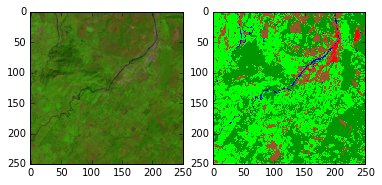

In [ ]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Forest
    (2, (0, 0, 255, 255)),  # Water
    (3, (0, 255, 0, 255)),  # Herbaceous
    (4, (160, 82, 45, 255)),  # Barren
    (5, (255, 0, 0, 255))  # Urban
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img543)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

## Wrapup

We've seen how we can use `scikit-learn` to implement the Random Forest classifier for land cover classification. A couple future directions that immediately follow this tutorial include:

+ Extend the lessons learned in the [visualization chapter](chapter_3_visualization.ipynb) to explore the class separability along various dimensions of the data. For example, plot the SWIR1 band against the NIR band and label each point in the scatter plot a different color according to the training data label.
+ Add additional features - would using NDVI as well as the spectral bands improve our classification?
+ `scikit-learn` includes many machine learning classifiers -- are any of these better than Random Forest for our goal?
+ We've only worked using a single date of imagery -- we could perform a direct classification of change using two dates
+ This approach only leverages the spectral information in Landsat. What would happen if we looked into some spatial information metrics like incorporating moving window statistics? For more on this, see [chapter 7](chapter_6_spatial.ipynb).

We've seen how Random Forest can come up with an estimate of the classification accuracy using the "Out-of-Bag" samples. While this may be a useful metric, we will need to perform a proper accuracy assessment based on a probability sample to conclude anything about the accuracy of the entire area. With the information from the accuracy assessment, we will be able not only to tell how good the map is, but more importantly we will be able to come up with statistically defensible unbiased estimates with confidence intervals of the land cover class areas in the map. For more information, see [Olofsson, *et. al.*, 2013](http://www.sciencedirect.com/science/article/pii/S0034425712004191).